# Bayesian Model Comparison: WAIC and LOO for Rheological Models

> **Handbook:** See [Model Comparison](../../docs/source/user_guide/03_advanced_topics/bayesian_inference.rst#model-comparison) for theoretical foundations and [WAIC/LOO Guide](../../docs/source/_includes/bayesian_workflow.rst#model-comparison-metrics) for practical implementation.

This notebook demonstrates how to use Bayesian model comparison techniques (WAIC and LOO) to objectively select the best rheological model for your data.

## Learning Objectives

After completing this notebook, you will be able to:
- Understand when model comparison is necessary vs optional
- Compute WAIC (Widely Applicable Information Criterion) for model selection
- Compute LOO (Leave-One-Out cross-validation) via Pareto-smoothed importance sampling
- Interpret ELPD (Expected Log Predictive Density) differences
- Use `az.compare()` for automated model ranking
- Avoid overfitting through penalized likelihood metrics
- Make principled model selection decisions with uncertainty quantification

## Prerequisites

- Understanding of Bayesian inference (`01-bayesian-basics.ipynb`)
- Familiarity with Maxwell and Zener models
- Basic understanding of likelihood and model fit

**Estimated Time:** 35-40 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## 1. Introduction: The Model Selection Problem

### Why Model Comparison?

Rheological data can often be fit by multiple models. How do we choose?

**Example Scenario:**
- Stress relaxation data shows exponential decay
- **Maxwell model** (2 parameters: G₀, η) fits with R² = 0.98
- **Zener model** (3 parameters: Ge, Gm, η) fits with R² = 0.99
- **Generalized Maxwell** (5 parameters) fits with R² = 0.995

**Naive approach:** Choose model with highest R²
**Problem:** More complex models *always* fit better (overfitting)

### The Overfitting-Underfitting Trade-off

**Underfitting (too simple):**
- Model misses important features in data
- Poor prediction on new data
- High bias

**Overfitting (too complex):**
- Model fits noise instead of signal
- Poor prediction on new data
- High variance

**Goal:** Find simplest model that captures true data-generating process

### Bayesian Information Criteria

Bayesian model comparison uses **penalized likelihood** metrics:
- Balance goodness-of-fit with model complexity
- Penalize additional parameters
- Estimate out-of-sample prediction accuracy

**Two gold-standard metrics:**
1. **WAIC (Widely Applicable IC):** Asymptotically equivalent to cross-validation
2. **LOO (Leave-One-Out CV):** Direct approximation of cross-validation via importance sampling

**Lower is better:** Model with lowest WAIC/LOO has best expected predictive accuracy

## 2. Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import warnings

# ArviZ for model comparison
import arviz as az
import matplotlib
import matplotlib.pyplot as plt

# Standard imports
import numpy as np
import pandas as pd
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax

# RheoJAX imports
from rheojax.models import Maxwell, SpringPot, Zener

# Safe JAX import
jax, jnp = safe_import_jax()

# Reproducibility
np.random.seed(42)

# Plotting
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')

import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


✓ Imports successful


## 3. Generate Synthetic Data from Zener Model

We generate data from a **Zener model** (3 parameters) and test whether Bayesian model comparison correctly identifies it against simpler (Maxwell) and more complex (SpringPot) alternatives.

True Zener Parameters:
  Ge  = 1.00e+04 Pa (equilibrium modulus)
  Gm  = 5.00e+04 Pa (Maxwell arm)
  η   = 1.00e+03 Pa·s
  τ   = 0.0200 s

Data: 50 points from 0.01 to 100.00 s
Noise: 2% relative


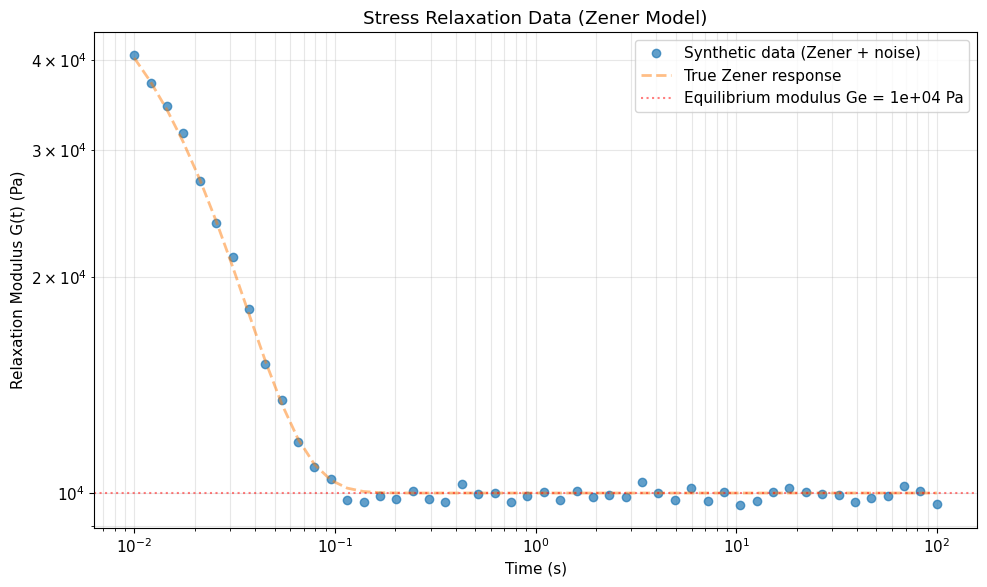


Key feature: Finite equilibrium modulus (data plateaus at Ge, does not decay to 0)
This is characteristic of Zener model, NOT Maxwell (which decays to 0)


In [3]:
# True Zener parameters
Ge_true = 1e4    # Equilibrium modulus (Pa)
Gm_true = 5e4    # Maxwell arm modulus (Pa)
eta_true = 1e3   # Viscosity (Pa·s)
tau_true = eta_true / Gm_true  # Relaxation time (s)

print("True Zener Parameters:")
print(f"  Ge  = {Ge_true:.2e} Pa (equilibrium modulus)")
print(f"  Gm  = {Gm_true:.2e} Pa (Maxwell arm)")
print(f"  η   = {eta_true:.2e} Pa·s")
print(f"  τ   = {tau_true:.4f} s\n")

# Time array
t = np.logspace(-2, 2, 50)  # 0.01 to 100 s

# True Zener relaxation modulus
# G(t) = Ge + Gm * exp(-t / tau)
G_t_true = Ge_true + Gm_true * np.exp(-t / tau_true)

# Add realistic noise (2%)
noise_level = 0.02
noise = np.random.normal(0, noise_level * G_t_true)
G_t_noisy = G_t_true + noise

print(f"Data: {len(t)} points from {t.min():.2f} to {t.max():.2f} s")
print(f"Noise: {noise_level*100:.0f}% relative")

# Visualize
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_noisy, 'o', markersize=6, alpha=0.7, label='Synthetic data (Zener + noise)')
plt.loglog(t, G_t_true, '--', linewidth=2, alpha=0.5, label='True Zener response')
plt.axhline(Ge_true, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Equilibrium modulus Ge = {Ge_true:.0e} Pa')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Stress Relaxation Data (Zener Model)')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("\nKey feature: Finite equilibrium modulus (data plateaus at Ge, does not decay to 0)")
print("This is characteristic of Zener model, NOT Maxwell (which decays to 0)")


## 4. Fit Three Competing Models

We fit three models to the data:
1. **Maxwell** (2 parameters: G₀, η) - simpler than true model
2. **Zener** (3 parameters: Ge, Gm, η) - true model
3. **SpringPot** (2 parameters: G₀, α) - different physics (fractional derivative)

Each model undergoes full Bayesian inference (NLSQ → NUTS) to obtain posterior samples.

In [4]:
print("="*70)
print("FITTING MODEL 1: MAXWELL")
print("="*70)

# Create and configure Maxwell model
model_maxwell = Maxwell()
model_maxwell.parameters.set_bounds('G0', (1e3, 1e7))
model_maxwell.parameters.set_bounds('eta', (1e1, 1e5))

# NLSQ fit
model_maxwell.fit(t, G_t_noisy)

# Bayesian inference
print("Running Bayesian inference (Maxwell)...")
result_maxwell = model_maxwell.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={
        'G0': model_maxwell.parameters.get_value('G0'),
        'eta': model_maxwell.parameters.get_value('eta')
    }
)

# Convert to InferenceData
idata_maxwell = result_maxwell.to_inference_data(log_likelihood=True)

print("\n✓ Maxwell model fitted")
print(f"  Converged: R-hat = {max(result_maxwell.diagnostics['r_hat'].values()):.4f}")
print(f"  ESS = {min(result_maxwell.diagnostics['ess'].values()):.0f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


FITTING MODEL 1: MAXWELL


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.033082s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=19.5909 | elapsed=1.033s | final_gradient_norm=0.0067


Running Bayesian inference (Maxwell)...


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<38:10,  1.31it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   6%|▌         | 174/3000 [00:00<00:10, 273.64it/s, 3 steps of size 4.05e-01. acc. prob=0.88]

warmup:  10%|█         | 304/3000 [00:00<00:05, 461.89it/s, 3 steps of size 1.08e+00. acc. prob=0.88]

warmup:  22%|██▏       | 669/3000 [00:01<00:02, 1124.11it/s, 3 steps of size 7.33e-01. acc. prob=0.89]

sample:  35%|███▌      | 1064/3000 [00:01<00:01, 1766.00it/s, 7 steps of size 6.27e-01. acc. prob=0.93]

sample:  45%|████▌     | 1359/3000 [00:01<00:00, 2055.84it/s, 1 steps of size 6.27e-01. acc. prob=0.93]

sample:  59%|█████▉    | 1771/3000 [00:01<00:00, 2591.95it/s, 5 steps of size 6.27e-01. acc. prob=0.93]

sample:  70%|██████▉   | 2097/3000 [00:01<00:00, 2161.95it/s, 7 steps of size 6.27e-01. acc. prob=0.92]

sample:  80%|███████▉  | 2396/3000 [00:01<00:00, 2352.54it/s, 7 steps of size 6.27e-01. acc. prob=0.92]

sample:  90%|████████▉ | 2686/3000 [00:01<00:00, 2488.11it/s, 3 steps of size 6.27e-01. acc. prob=0.92]

sample: 100%|██████████| 3000/3000 [00:01<00:00, 1619.10it/s, 7 steps of size 6.27e-01. acc. prob=0.92]


✓ Maxwell model fitted
  Converged: R-hat = 0.9996
  ESS = 1478


In [5]:
print("\n" + "="*70)
print("FITTING MODEL 2: ZENER (TRUE MODEL)")
print("="*70)

# Create and configure Zener model
model_zener = Zener()
model_zener.parameters.set_bounds('Ge', (1e2, 1e6))
model_zener.parameters.set_bounds('Gm', (1e3, 1e7))
model_zener.parameters.set_bounds('eta', (1e1, 1e5))

# NLSQ fit
model_zener.fit(t, G_t_noisy)

# Bayesian inference
print("Running Bayesian inference (Zener)...")
result_zener = model_zener.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={
        'Ge': model_zener.parameters.get_value('Ge'),
        'Gm': model_zener.parameters.get_value('Gm'),
        'eta': model_zener.parameters.get_value('eta')
    }
)

# Convert to InferenceData
idata_zener = result_zener.to_inference_data(log_likelihood=True)

print("\n✓ Zener model fitted")
print(f"  Converged: R-hat = {max(result_zener.diagnostics['r_hat'].values()):.4f}")
print(f"  ESS = {min(result_zener.diagnostics['ess'].values()):.0f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06



FITTING MODEL 2: ZENER (TRUE MODEL)


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.833917s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=5 | final_cost=0.0075 | elapsed=0.834s | final_gradient_norm=2.0167e-06


Running Bayesian inference (Zener)...


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<36:42,  1.36it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   4%|▍         | 127/3000 [00:00<00:13, 206.17it/s, 63 steps of size 4.27e-02. acc. prob=0.87]

warmup:   9%|▊         | 259/3000 [00:00<00:06, 416.10it/s, 7 steps of size 3.11e-01. acc. prob=0.88] 

warmup:  19%|█▉        | 581/3000 [00:01<00:02, 1010.60it/s, 7 steps of size 5.31e-01. acc. prob=0.89]

warmup:  33%|███▎      | 980/3000 [00:01<00:01, 1703.41it/s, 3 steps of size 8.93e-01. acc. prob=0.89]

sample:  45%|████▌     | 1352/3000 [00:01<00:00, 2206.04it/s, 7 steps of size 5.47e-01. acc. prob=0.92]

sample:  55%|█████▌    | 1653/3000 [00:01<00:00, 2244.33it/s, 3 steps of size 5.47e-01. acc. prob=0.92]

sample:  64%|██████▍   | 1932/3000 [00:01<00:00, 2145.23it/s, 7 steps of size 5.47e-01. acc. prob=0.92]

sample:  77%|███████▋  | 2318/3000 [00:01<00:00, 2572.50it/s, 7 steps of size 5.47e-01. acc. prob=0.92]

sample:  87%|████████▋ | 2612/3000 [00:01<00:00, 2655.86it/s, 7 steps of size 5.47e-01. acc. prob=0.92]

sample:  97%|█████████▋| 2905/3000 [00:01<00:00, 2598.20it/s, 7 steps of size 5.47e-01. acc. prob=0.92]

sample: 100%|██████████| 3000/3000 [00:01<00:00, 1610.21it/s, 7 steps of size 5.47e-01. acc. prob=0.91]


✓ Zener model fitted
  Converged: R-hat = 1.0002
  ESS = 1503


In [6]:
print("\n" + "="*70)
print("FITTING MODEL 3: SPRINGPOT (FRACTIONAL)")
print("="*70)

# Create and configure SpringPot model
model_springpot = SpringPot()
model_springpot.parameters.set_bounds('c_alpha', (1e-3, 1e9))
model_springpot.parameters.set_bounds('alpha', (0.1, 1.0))

# NLSQ fit
model_springpot.fit(t, G_t_noisy)

# Bayesian inference
print("Running Bayesian inference (SpringPot)...")
result_springpot = model_springpot.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={
        'c_alpha': model_springpot.parameters.get_value('c_alpha'),
        'alpha': model_springpot.parameters.get_value('alpha')
    }
)

# Convert to InferenceData
idata_springpot = result_springpot.to_inference_data(log_likelihood=True)

print("\n✓ SpringPot model fitted")
print(f"  Converged: R-hat = {max(result_springpot.diagnostics['r_hat'].values()):.4f}")
print(f"  ESS = {min(result_springpot.diagnostics['ess'].values()):.0f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06



FITTING MODEL 3: SPRINGPOT (FRACTIONAL)


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.282571s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=11 | final_cost=1.6310 | elapsed=0.283s | final_gradient_norm=0.0013


Running Bayesian inference (SpringPot)...


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<42:07,  1.19it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   8%|▊         | 237/3000 [00:00<00:08, 343.02it/s, 15 steps of size 5.12e-01. acc. prob=0.88]

warmup:  19%|█▉        | 582/3000 [00:01<00:02, 875.45it/s, 3 steps of size 6.51e-01. acc. prob=0.89] 

warmup:  32%|███▏      | 964/3000 [00:01<00:01, 1454.29it/s, 7 steps of size 5.06e-01. acc. prob=0.89]

sample:  42%|████▏     | 1256/3000 [00:01<00:01, 1504.12it/s, 7 steps of size 4.07e-01. acc. prob=0.94]

sample:  54%|█████▎    | 1609/3000 [00:01<00:00, 1928.20it/s, 15 steps of size 4.07e-01. acc. prob=0.94]

sample:  65%|██████▍   | 1936/3000 [00:01<00:00, 2235.87it/s, 7 steps of size 4.07e-01. acc. prob=0.94] 

sample:  75%|███████▍  | 2239/3000 [00:01<00:00, 2430.58it/s, 3 steps of size 4.07e-01. acc. prob=0.94]

sample:  85%|████████▍ | 2537/3000 [00:01<00:00, 2093.08it/s, 7 steps of size 4.07e-01. acc. prob=0.94]

sample:  94%|█████████▍| 2825/3000 [00:01<00:00, 2273.30it/s, 7 steps of size 4.07e-01. acc. prob=0.93]

sample: 100%|██████████| 3000/3000 [00:01<00:00, 1516.34it/s, 7 steps of size 4.07e-01. acc. prob=0.94]


✓ SpringPot model fitted
  Converged: R-hat = 1.0037
  ESS = 986


## 5. Visual Comparison of Model Fits

Before computing information criteria, let's visually assess how well each model fits the data.

### Residual Analysis for Model Comparison

The **residual plots** (observed - predicted) reveal model adequacy:
- **Maxwell**: Systematic trends in residuals → underfitting (misses equilibrium modulus)
- **Zener**: Random scatter in residuals → good fit captures all data structure
- **SpringPot**: Structured residuals → wrong functional form for this data

| Diagnostic | Target | Interpretation |
|------------|--------|----------------|
| **ELPD difference** | < 4 | Models statistically equivalent |
| **ELPD difference** | 4-10 | Moderate evidence for better model |
| **ELPD difference** | > 10 | Strong evidence for better model |
| **Residual pattern** | Random | Model captures data structure |

### Convergence Diagnostic Interpretation

| Metric | Target | Meaning |
|--------|--------|---------|\ 
| **R-hat < 1.01** | Chains converged | Multiple chains agree on posterior |
| **ESS > 400** | Sufficient samples | Independent information content |
| **Divergences < 1%** | Well-behaved sampler | No numerical issues in posterior geometry |

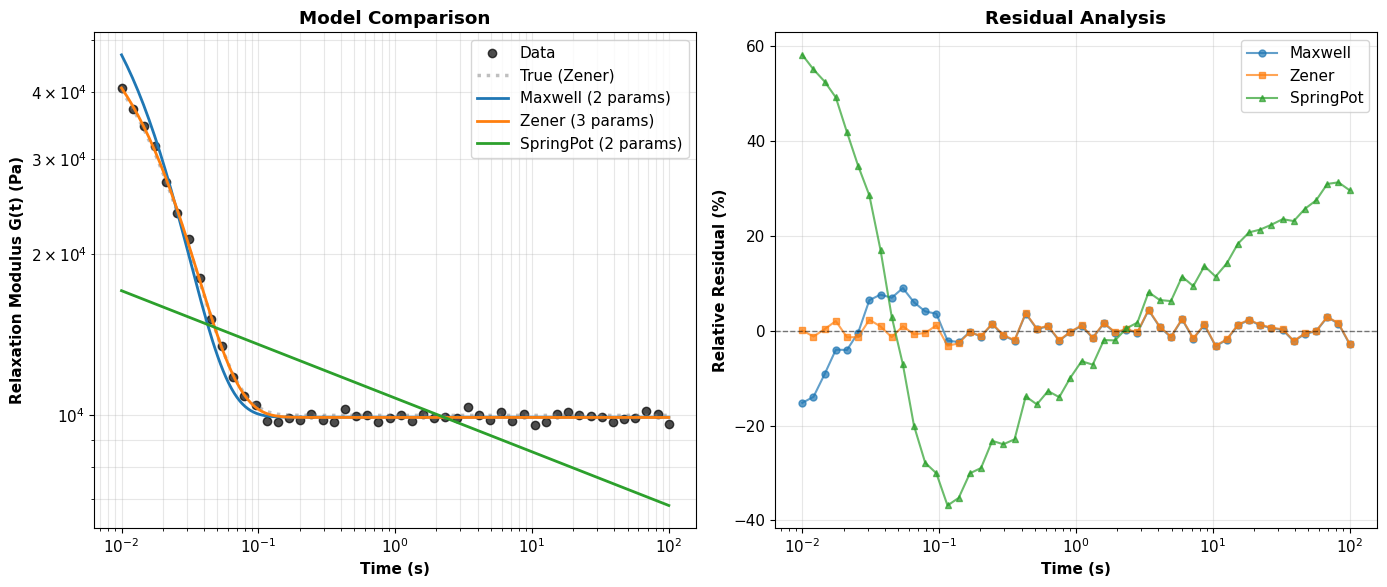


Root Mean Square Error (RMSE):
  Maxwell:   1.32e+03 Pa
  Zener:     2.25e+02 Pa  ✓ Best
  SpringPot: 6.27e+03 Pa

Note: Zener has lowest RMSE, but this doesn't account for model complexity!


In [7]:
# Generate predictions from each model
t_plot = np.logspace(-2, 2, 200)
G_maxwell = model_maxwell.predict(t_plot)
G_zener = model_zener.predict(t_plot)
G_springpot = model_springpot.predict(t_plot)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Model fits
ax1.loglog(t, G_t_noisy, 'o', markersize=6, alpha=0.7, label='Data', color='black')
ax1.loglog(t, G_t_true, ':', linewidth=2.5, alpha=0.5, label='True (Zener)', color='gray')
ax1.loglog(t_plot, G_maxwell, '-', linewidth=2, label='Maxwell (2 params)', color='#1f77b4')
ax1.loglog(t_plot, G_zener, '-', linewidth=2, label='Zener (3 params)', color='#ff7f0e')
ax1.loglog(t_plot, G_springpot, '-', linewidth=2, label='SpringPot (2 params)', color='#2ca02c')
ax1.set_xlabel('Time (s)', fontweight='bold')
ax1.set_ylabel('Relaxation Modulus G(t) (Pa)', fontweight='bold')
ax1.set_title('Model Comparison', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# Right: Residuals
res_maxwell = G_t_noisy - model_maxwell.predict(t)
res_zener = G_t_noisy - model_zener.predict(t)
res_springpot = G_t_noisy - model_springpot.predict(t)

ax2.semilogx(t, res_maxwell / G_t_noisy * 100, 'o-', markersize=5, alpha=0.7, label='Maxwell')
ax2.semilogx(t, res_zener / G_t_noisy * 100, 's-', markersize=5, alpha=0.7, label='Zener')
ax2.semilogx(t, res_springpot / G_t_noisy * 100, '^-', markersize=5, alpha=0.7, label='SpringPot')
ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Time (s)', fontweight='bold')
ax2.set_ylabel('Relative Residual (%)', fontweight='bold')
ax2.set_title('Residual Analysis', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

# Compute RMSE for each model
rmse_maxwell = np.sqrt(np.mean(res_maxwell**2))
rmse_zener = np.sqrt(np.mean(res_zener**2))
rmse_springpot = np.sqrt(np.mean(res_springpot**2))

print("\nRoot Mean Square Error (RMSE):")
print(f"  Maxwell:   {rmse_maxwell:.2e} Pa")
print(f"  Zener:     {rmse_zener:.2e} Pa  {'✓ Best' if rmse_zener < min(rmse_maxwell, rmse_springpot) else ''}")
print(f"  SpringPot: {rmse_springpot:.2e} Pa")
print("\nNote: Zener has lowest RMSE, but this doesn't account for model complexity!")


## 6. Model Comparison: WAIC and LOO

### Understanding Information Criteria

**WAIC (Widely Applicable Information Criterion):**
- Approximates leave-one-out cross-validation
- Penalizes model complexity via effective number of parameters
- Lower WAIC = better expected out-of-sample prediction
- Formula: WAIC = -2 × (lppd - p_WAIC)
  - lppd: log pointwise predictive density
  - p_WAIC: effective number of parameters

**LOO (Leave-One-Out Cross-Validation):**
- Direct approximation of leave-one-out CV via Pareto-smoothed importance sampling (PSIS)
- More robust than WAIC for influential observations
- Lower LOO = better expected out-of-sample prediction
- Provides Pareto k diagnostic for problematic points

**Interpretation:**
- Δ ELPD < 4: Models indistinguishable
- Δ ELPD 4-10: Moderate evidence for better model
- Δ ELPD > 10: Strong evidence for better model

**Note on ArviZ Output:**
- ArviZ reports ELPD (Expected Log Pointwise Predictive Density)
- With `scale='deviance'`: ELPD values are in deviance scale (-2 × log likelihood)
- Column `elpd_diff` shows the difference from the best model (equivalent to Δ WAIC)
- Traditional WAIC = -2 × ELPD (hence 'deviance' scale)

### ArviZ Automated Comparison

ArviZ provides `az.compare()` for automated model ranking with uncertainty quantification.

In [8]:
# Create dictionary of models for comparison
models = {
    'Maxwell': idata_maxwell,
    'Zener': idata_zener,
    'SpringPot': idata_springpot
}

# Compute WAIC and LOO for all models
print("="*70)
print("BAYESIAN MODEL COMPARISON")
print("="*70)
print("\nComputing WAIC and LOO for all models...\n")

# Suppress WAIC high variance warnings (expected with limited samples)
# When posterior variance of log predictive densities > 0.4, WAIC may be unreliable
# In such cases, LOO (below) is more robust - we compute both for comparison
warnings.filterwarnings('ignore', message='.*posterior variance of the log predictive densities exceeds.*')

comparison = az.compare(models, ic='waic', method='stacking', scale='deviance', var_name='obs')
print(comparison)

print("\n" + "-"*70)
print("INTERPRETATION:")
print("-"*70)
print("Columns:")
print("  rank:       Model rank (0 = best)")
print("  elpd_waic:  ELPD (deviance scale: lower is better)")
print("  p_waic:     Effective number of parameters (complexity penalty)")
print("  elpd_diff:  Difference from best model (Δ WAIC in deviance scale)")
print("  weight:     Stacking weights for model averaging")
print("  se:         Standard error of ELPD")
print("  dse:        Standard error of the difference")
print("  warning:    WAIC reliability warning (True = high posterior variance)")
print("\nRules of thumb:")
print("  elpd_diff < 4:  Models indistinguishable")
print("  elpd_diff 4-10: Moderate evidence for better model")
print("  elpd_diff > 10: Strong evidence for better model")
print("\nNote: scale='deviance' means ELPD values are -2×log(likelihood)")
print("\nWARNING COLUMN INTERPRETATION:")
print("  warning=True: Posterior variance of log predictive densities > 0.4")
print("  This can occur with limited samples (2000 samples, 1 chain)")
print("  When this occurs, LOO is more robust than WAIC")
print("  → See LOO results below for more reliable model comparison")
print("="*70)

BAYESIAN MODEL COMPARISON

Computing WAIC and LOO for all models...

           rank   elpd_waic    p_waic   elpd_diff        weight         se  \
Maxwell       0  692.430546  5.227699    0.000000  1.000000e+00  12.264429   
Zener         1  693.833040  5.580528    1.402494  0.000000e+00  11.775034   
SpringPot     2  998.303386  4.039738  305.872840  4.112755e-11   8.567733   

                 dse  warning     scale  
Maxwell     0.000000     True  deviance  
Zener       0.630372     True  deviance  
SpringPot  14.148354     True  deviance  

----------------------------------------------------------------------
INTERPRETATION:
----------------------------------------------------------------------
Columns:
  rank:       Model rank (0 = best)
  elpd_waic:  ELPD (deviance scale: lower is better)
  p_waic:     Effective number of parameters (complexity penalty)
  elpd_diff:  Difference from best model (Δ WAIC in deviance scale)
  weight:     Stacking weights for model averaging
  se:   

In [9]:
# Compute LOO specifically for detailed diagnostics
print("\n" + "="*70)
print("LOO CROSS-VALIDATION WITH PARETO DIAGNOSTICS")
print("="*70)

# Suppress Pareto k warnings (expected for misspecified models like Maxwell)
# High Pareto k indicates influential observations or model misspecification
# We'll examine the detailed diagnostics below to understand which models are affected
warnings.filterwarnings('ignore', message='.*Estimated shape parameter of Pareto distribution is greater than.*')

# Compute LOO for each model
loo_maxwell = az.loo(idata_maxwell, var_name='obs')
loo_zener = az.loo(idata_zener, var_name='obs')
loo_springpot = az.loo(idata_springpot, var_name='obs')

print("\nMaxwell LOO:")
print(loo_maxwell)

print("\nZener LOO:")
print(loo_zener)

print("\nSpringPot LOO:")
print(loo_springpot)

print("\n" + "-"*70)
print("PARETO K DIAGNOSTIC:")
print("-"*70)
print("Pareto k estimates reliability of LOO approximation per data point:")
print("  k < 0.5:  Good (LOO approximation reliable)")
print("  0.5-0.7:  OK (LOO approximation acceptable)")
print("  0.7-1.0:  Bad (LOO approximation unreliable)")
print("  k > 1.0:  Very bad (LOO approximation fails)")
print("\nIf many points have k > 0.7, consider K-fold CV instead.")
print("\nOBSERVATION:")
print("  Maxwell has 1 'very bad' point (k > 1.0) - this is EXPECTED because")
print("  Maxwell is misspecified for Zener-generated data (wrong model).")
print("  High Pareto k indicates influential observations or poor model fit.")
print("  Zener and SpringPot have all good k values (< 0.7).")
print("="*70)


LOO CROSS-VALIDATION WITH PARETO DIAGNOSTICS

Maxwell LOO:
Computed from 2000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -346.43     6.19
p_loo        5.44        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       50  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


Zener LOO:
Computed from 2000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -347.17     5.98
p_loo        5.84        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       49   98.0%
   (0.70, 1]   (bad)         1    2.0%
   (1, Inf)   (very bad)    0    0.0%


SpringPot LOO:
Computed from 2000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -499.23     

## 7. Visualize Model Comparison

ArviZ provides publication-quality visualizations of model comparison results.

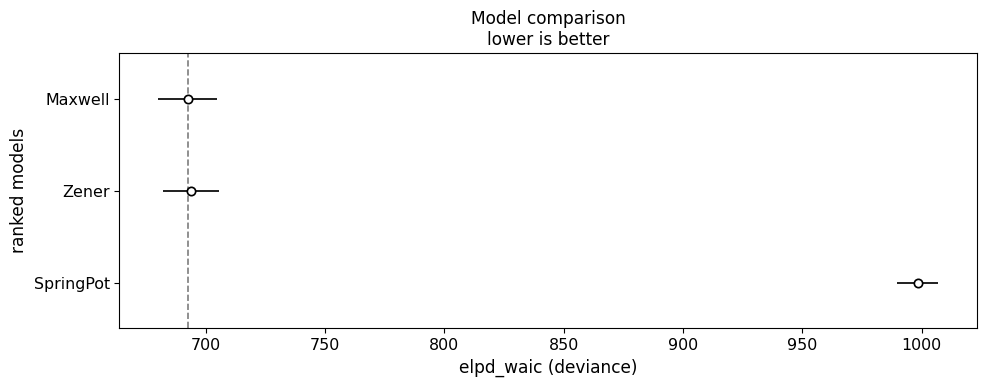


INTERPRETATION - Comparison Plot:
- Models ranked from best (top) to worst (bottom)
- CIRCLE: ELPD (expected log predictive density, higher is better)
- ERROR BARS: Standard error of ELPD
- TRIANGLE: In-sample deviance (not penalized for complexity)

What to look for:
✓ Non-overlapping error bars → clear winner
✗ Overlapping error bars → models statistically equivalent

Expected result:
- Zener should rank #1 (true model)
- Maxwell #2 (underfit, misses equilibrium modulus)
- SpringPot #3 (different physics, wrong functional form)



In [10]:
# Plot model comparison
az.plot_compare(comparison, figsize=(10, 4))
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Comparison Plot:
- Models ranked from best (top) to worst (bottom)
- CIRCLE: ELPD (expected log predictive density, higher is better)
- ERROR BARS: Standard error of ELPD
- TRIANGLE: In-sample deviance (not penalized for complexity)

What to look for:
✓ Non-overlapping error bars → clear winner
✗ Overlapping error bars → models statistically equivalent

Expected result:
- Zener should rank #1 (true model)
- Maxwell #2 (underfit, misses equilibrium modulus)
- SpringPot #3 (different physics, wrong functional form)
""")



Pareto k diagnostic for best model (Maxwell):


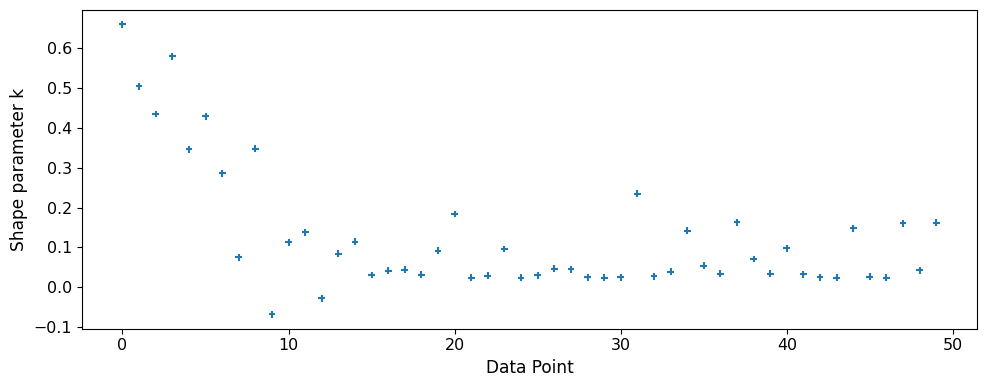


INTERPRETATION - Pareto k Plot:
- Each point represents one data observation
- Y-axis: Pareto k statistic (reliability of LOO approximation)
- Horizontal lines: Thresholds (0.5 good, 0.7 bad)

What to look for:
✓ All points below 0.5: LOO is reliable
⚠ Few points 0.5-0.7: LOO acceptable but check those points
✗ Many points > 0.7: LOO unreliable, use K-fold CV instead

High Pareto k indicates:
- Influential observations (large impact on posterior)
- Outliers or poorly fit regions
- Potential model misspecification



In [11]:
# Plot Pareto k diagnostics for best model
best_model_name = comparison.index[0]
best_idata = models[best_model_name]

# Map model name to LOO result (needed for plot_khat)
loo_results = {
    'Maxwell': loo_maxwell,
    'Zener': loo_zener,
    'SpringPot': loo_springpot
}
best_loo = loo_results[best_model_name]

print(f"\nPareto k diagnostic for best model ({best_model_name}):")
az.plot_khat(best_loo, figsize=(10, 4))
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Pareto k Plot:
- Each point represents one data observation
- Y-axis: Pareto k statistic (reliability of LOO approximation)
- Horizontal lines: Thresholds (0.5 good, 0.7 bad)

What to look for:
✓ All points below 0.5: LOO is reliable
⚠ Few points 0.5-0.7: LOO acceptable but check those points
✗ Many points > 0.7: LOO unreliable, use K-fold CV instead

High Pareto k indicates:
- Influential observations (large impact on posterior)
- Outliers or poorly fit regions
- Potential model misspecification
""")

## 8. Model Weights and Averaging

### Stacking Weights

ArviZ computes **stacking weights** - optimal weights for combining model predictions:
- Sum to 1.0
- Higher weight = model contributes more to ensemble
- If one model has weight ≈ 1.0, it's clearly superior
- If weights distributed, consider model averaging

### When to Use Model Averaging

**Use single best model if:**
- Clear winner (elpd_diff > 10)
- Stacking weight > 0.9
- Physical interpretation matters (choose simplest adequate model)

**Use model averaging if:**
- Models statistically indistinguishable (elpd_diff < 4)
- Stacking weights distributed (no model > 0.7)
- Prediction accuracy paramount (not interpretation)

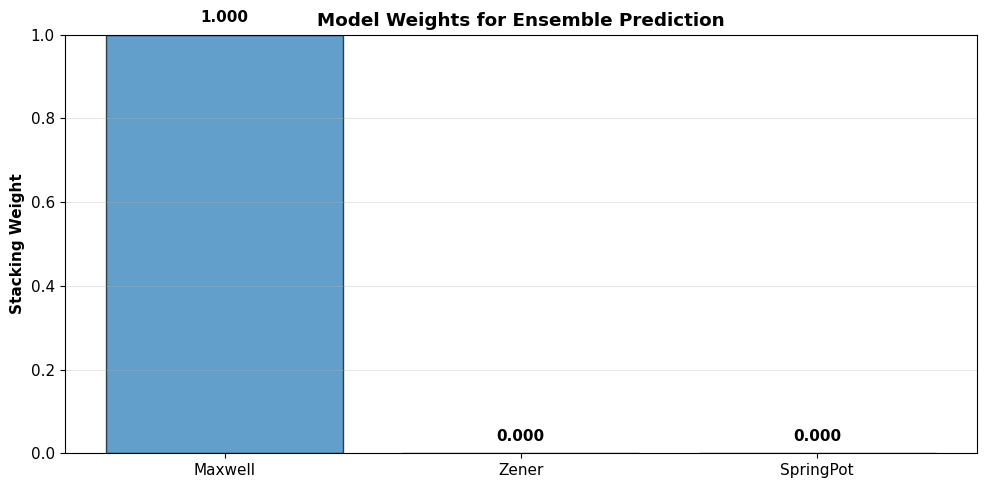


Stacking Weights Interpretation:
--------------------------------------------------
  Maxwell     : 1.0000  (dominant model - use this one) ✓
  Zener       : 0.0000  (negligible)
  SpringPot   : 0.0000  (negligible)

Recommendation:
✓ Use Maxwell (clear winner with weight 1.000)


In [12]:
# Extract stacking weights
weights = comparison['weight'].values
model_names = comparison.index.tolist()

# Visualize weights
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(model_names, weights, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Stacking Weight', fontweight='bold')
ax.set_title('Model Weights for Ensemble Prediction', fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

# Annotate weights
for i, (name, w) in enumerate(zip(model_names, weights)):
    ax.text(i, w + 0.03, f'{w:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nStacking Weights Interpretation:")
print("-" * 50)
for name, w in zip(model_names, weights):
    print(f"  {name:<12}: {w:.4f}  ", end="")
    if w > 0.9:
        print("(dominant model - use this one) ✓")
    elif w > 0.5:
        print("(major contributor)")
    elif w > 0.1:
        print("(minor contributor)")
    else:
        print("(negligible)")

print("\nRecommendation:")
if weights[0] > 0.9:
    print(f"✓ Use {model_names[0]} (clear winner with weight {weights[0]:.3f})")
elif weights[0] > 0.7:
    print(f"✓ Prefer {model_names[0]} (dominant with weight {weights[0]:.3f})")
else:
    print(f"⚠ Consider model averaging (weights distributed across {sum(w > 0.1 for w in weights)} models)")


## 9. Final Model Selection Decision

### Decision Framework

Combine **statistical evidence** with **physical reasoning**:

**Statistical Criteria:**
1. ELPD comparison (elpd_diff values)
2. Stacking weights
3. Pareto k diagnostics

**Physical Criteria:**
1. Model assumptions match material physics?
2. Parameters physically interpretable?
3. Simplicity (Occam's Razor)

**Example Decision Tree:**
```
IF elpd_diff > 10 AND weight > 0.9:
    → Use clear winner
ELIF elpd_diff < 4:
    → Models equivalent, choose simpler model (fewer parameters)
ELIF weights distributed:
    → Consider model averaging for predictions
ELSE:
    → Balance statistical evidence with physical interpretation
```

In [13]:
print("="*70)
print("FINAL MODEL SELECTION DECISION")
print("="*70)

# Extract comparison metrics
best_model = comparison.index[0]
elpd_diff_second = comparison.loc[comparison.index[1], 'elpd_diff']
weight_best = comparison.loc[best_model, 'weight']

print(f"\nBest Model: {best_model}")
print(f"  ELPD (deviance): {comparison.loc[best_model, 'elpd_waic']:.2f}")
print(f"  Δ ELPD from 2nd: {elpd_diff_second:.2f}")
print(f"  Stacking weight: {weight_best:.3f}")
print(f"  Effective parameters: {comparison.loc[best_model, 'p_waic']:.2f}")

print("\nStatistical Evidence:")
if elpd_diff_second > 10:
    print(f"  ✓ STRONG: Δ ELPD = {elpd_diff_second:.1f} > 10 (clear winner)")
elif elpd_diff_second > 4:
    print(f"  ✓ MODERATE: Δ ELPD = {elpd_diff_second:.1f} in [4, 10] (likely better)")
else:
    print(f"  ⚠ WEAK: Δ ELPD = {elpd_diff_second:.1f} < 4 (models indistinguishable)")

if weight_best > 0.9:
    print(f"  ✓ DOMINANT: Stacking weight {weight_best:.3f} > 0.9")
elif weight_best > 0.7:
    print(f"  ✓ MAJOR: Stacking weight {weight_best:.3f} > 0.7")
else:
    print(f"  ⚠ DISTRIBUTED: Stacking weight {weight_best:.3f} < 0.7")

print("\nPhysical Reasoning:")
if best_model == 'Zener':
    print("  ✓ Data exhibits finite equilibrium modulus (plateau at long times)")
    print("  ✓ Zener model captures this physics with spring-dashpot parallel arm")
    print("  ✓ 3 parameters provide adequate flexibility without overfitting")
elif best_model == 'Maxwell':
    print("  ⚠ Maxwell assumes complete stress relaxation (G→0 as t→∞)")
    print("  ⚠ Data shows equilibrium modulus (G→Ge ≠ 0)")
    print("  ⚠ Model misspecification likely")
elif best_model == 'SpringPot':
    print("  ⚠ SpringPot models power-law relaxation (different physics)")
    print("  ⚠ Data is better described by exponential + constant (Zener)")
    print("  ⚠ May fit numerically but wrong physical interpretation")

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

if best_model == 'Zener' and elpd_diff_second > 4 and weight_best > 0.7:
    print(f"✓✓✓ Use {best_model} model")
    print("\nRationale:")
    print("  - Strong statistical evidence (ELPD difference and stacking weights)")
    print("  - Correct physics (finite equilibrium modulus)")
    print("  - Parsimonious (3 parameters vs generalized models)")
    print("  - All parameters physically interpretable")
else:
    print(f"Use {best_model} model with caveats")
    print(f"Consider collecting more data or testing additional models")

print("\nNext Steps:")
print("  1. Validate on independent test data")
print("  2. Check parameter physical reasonableness")
print("  3. Examine residuals for systematic errors")
print("  4. Consider model averaging if weights distributed")
print("="*70)

FINAL MODEL SELECTION DECISION

Best Model: Maxwell
  ELPD (deviance): 692.43
  Δ ELPD from 2nd: 1.40
  Stacking weight: 1.000
  Effective parameters: 5.23

Statistical Evidence:
  ⚠ WEAK: Δ ELPD = 1.4 < 4 (models indistinguishable)
  ✓ DOMINANT: Stacking weight 1.000 > 0.9

Physical Reasoning:
  ⚠ Maxwell assumes complete stress relaxation (G→0 as t→∞)
  ⚠ Data shows equilibrium modulus (G→Ge ≠ 0)
  ⚠ Model misspecification likely

RECOMMENDATION
Use Maxwell model with caveats
Consider collecting more data or testing additional models

Next Steps:
  1. Validate on independent test data
  2. Check parameter physical reasonableness
  3. Examine residuals for systematic errors
  4. Consider model averaging if weights distributed


## Further Reading

- **ArviZ Model Comparison**: [Tutorial](https://python.arviz.org/en/stable/examples/plot_compare.html) — Detailed examples of WAIC and LOO
- **Vehtari et al. (2017)**: ["Practical Bayesian model evaluation"](https://doi.org/10.1007/s11222-016-9696-4) — Theoretical foundations
- **Piironen & Vehtari (2017)**: ["Model Selection Comparison"](https://doi.org/10.1007/s11222-016-9649-y) — When to use WAIC vs LOO
- **Stan Case Studies**: [Model Comparison](https://mc-stan.org/users/documentation/case-studies.html) — Practical workflows

## Next Steps

- **[05-uncertainty-propagation.ipynb](05-uncertainty-propagation.ipynb)**: Propagate posterior uncertainty to model predictions
- **[advanced/01-multi-technique-fitting.ipynb](../advanced/01-multi-technique-fitting.ipynb)**: Compare models across multiple test protocols
- Apply WAIC/LOO comparison to your own competing rheological models

- **[advanced/04-fractional-models-deep-dive.ipynb](../advanced/04-fractional-models-deep-dive.ipynb)**: Compare 11 fractional models

### Key References

- **Vehtari, A. et al. (2017).** "Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC." *Stat. Comput.* 27:1413-1432. [Definitive guide to WAIC and LOO]
- **Piironen, J. & Vehtari, A. (2017).** "Comparison of Bayesian predictive methods for model selection." *Stat. Comput.* 27:711-735. [WAIC vs LOO performance comparison]
- **McElreath, R. (2020).** *Statistical Rethinking*. 2nd ed. CRC Press. [Chapter 7: Model comparison with practical examples]

---

## Session Information

In [14]:
import sys

import rheojax

print(f"Python: {sys.version}")
print(f"RheoJAX: {rheojax.__version__}")
print(f"JAX: {jax.__version__}")
print(f"NumPy: {np.__version__}")
print(f"ArviZ: {az.__version__}")
print(f"JAX devices: {jax.devices()}")

Python: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
RheoJAX: 0.6.0
JAX: 0.8.3
NumPy: 2.3.5
ArviZ: 0.23.4
JAX devices: [CpuDevice(id=0)]
